## Ice Temperature (icetemp) Package Tutorial

In [1]:
# Standard imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Imports from ice temperature estimation package
import icetemp
import icetemp.data_io as io
import icetemp.model as m

# Overview

This package is intended to infer the change in temperature at the surface of the Antarctic ice from measurements of temperature $(^\circ \text{C})$ as a function of depth (m) from thermistor data provided by the AMANDA and IceCube collaborations. Four data sets are provided between 2002 and 2010 (2002, 2007, 2009, and 2010) in [public data releases](https://icecube.wisc.edu/data-releases/2020/05/south-pole-ice-temperature/) by the collaborations. In order to obtain the temperature at the surface, we postulate a quadratic relationship between temperature and depth, and then extract the intercept (a linear relationship is also considered). Gaussian process regression is subsequently used on the inferred surface temperatures from different years to obtain a function which describes how the temperature has changed in the Antarctic over the aforementioned time period.   

This tutorial notebook details the generative model used to analyze the temperature data as a function of depth. The model involves uniform priors for each term of the polynomials studied and a normal likelihood to describe the Gaussian uncertainties on the temperature. These uncertaintes/sources of noise are directly related to the thermistor technical limitations. In this portion of the notebook, the generative models used to describe the dependence of temperature on depth are presented. In subsequent sections, the functions used to infer the paramaters of each model are demonstrated; one function performs least-squares fitting, while the other utilizes Markov chain Monte Carlo (MCMC) sampling. Finally, Gaussian process regression is used to infer the change in temperature at the surface of the Antarctic ice.
___
## Linear dependence of temperature on depth

In the case of a linear relationship between temperature and depth, we have $ T = f(d) = m \cdot d + b$ where $d$ is the depth and $T$ is the temperature. For each of the true $T$ values with Gaussian uncertainties, the frequency distribution $p(T_i|d_i,\sigma_{Ti},m,b)$ for $T_i$ is 

$$ p(T_i|d_i,\sigma_T,m,b) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(T_i - md_i - b)^2}{2\sigma_T^2}\Big).$$

In our model, $\sigma_T$ represents the temperature uncertainties, and $m$ and $b$ are the coefficients of the linear fit.

We have no prior information about the dependence of temperature on depth, and for that reason we shall consider a "Flat" prior for our parameters. Regarding the intecept, we _could_ assume it will be in the expected temperature range at ground level in the Antarctic, which ranges from -20°C (summer) to -60°C (winter).  We will work with the simplest model that assigns flat priors to all of the parameters in our model. Our statistical model is defined as follows:

$$ m \sim \text{Uniform}( m^l, m^u) \rightarrow m \sim \text{Uniform}(-\infty ,\infty)$$

$$ b \sim \text{Uniform}( b^l, b^u) \rightarrow b \sim \text{Uniform}(-\infty ,\infty)$$ where we define $\mu_i = m \cdot d_i + b$

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood for the set of parameters $(m, b)$ is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(y_i - mx_i - b)^2}{2\sigma_T^2}\Big) $$ where $y_i$ and $x_i$ are data points for temperature and depth, respectively.
___
## Quadratic dependence of temperature on depth
In the case of a quadratic relationship between temperature and depth, we have $ T = f(d) = q \cdot d^2 + m \cdot d + b$ where $d$ is the depth and $T$ is the temperature. For each of the true $T$ values with Gaussian uncertainties, the frequency distribution $p(T_i|d_i,\sigma_{Ti},m,b)$ for $T_i$ is 

$$ p(T_i|d_i,\sigma_{T},m,b) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(T_i - q d_i^2 - md_i - b)^2}{2\sigma_T^2}\Big).$$

In our model, $\sigma_T$ represents the temperature uncertainties, and $q$, $m$, and $b$ are the coefficients of the quadratic fit.

As previously mentioned, we have no prior information about the dependence of temperature over depth, and for that reason we shall consider a "Flat" prior for our parameters. Regarding the intecept we _could_ assume it will be in the expected temperature at ground level in the Antarctic, which ranges from -20°C (summer) to -60°C (winter).  We will again work with the simplest model that assigns flat priors to all of the parameters in our model. Our statistical model is defined as follows:

$$ q \sim \text{Uniform}( q^l, q^u) \rightarrow q \sim \text{Uniform}(-\infty , \infty)$$

$$ m \sim \text{Uniform}( m^l, m^u) \rightarrow m \sim \text{Uniform}(-\infty ,\infty)$$

$$ b \sim \text{Uniform}( b^l, b^u) \rightarrow b \sim \text{Uniform}(-\infty , \infty)$$ 

where we define $\mu_i = q \cdot d_i^2 + m \cdot d_i + b$

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood for the set of parameters ($q$, $m$, $b$) is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(y_i - q x_i^2 - mx_i - b)^2}{2\sigma_T^2}\Big) $$ where $y_i$ and $x_i$ are data points for temperature and depth, respectively.
___
___

## Let's take a look at our data!

The function `load_ice_data()` in `data_io.py` returns a Pandas DataFrame which encapsulates the data and metadata associated with a specific data set. Temperature measurements $(^\circ \text{C})$, depth measurements (m), year of data taking, temperature uncertainty ($\sigma_T = 0.1 ^\circ \text{C}$), and depth uncertainty ($\sigma_d = 2$ m) are all included.

In [2]:
# load some (real) data
ex_data = io.load_ice_data("icecube_temp.2007.txt", data_year=2007,temp_errors=0.1, depth_errors=2)
print(ex_data)

    Temperature    Depth  data_year  temp_errors  depth_errors
0        -28.76  2078.18       2007          0.1             2
1        -25.09  2214.35       2007          0.1             2
2        -20.93  2350.52       2007          0.1             2
3        -26.51  2161.09       2007          0.1             2
4        -22.42  2297.25       2007          0.1             2
5        -17.89  2433.42       2007          0.1             2
6        -25.79  2195.40       2007          0.1             2
7        -21.55  2331.57       2007          0.1             2
8        -18.23  2433.69       2007          0.1             2
9        -26.26  2171.54       2007          0.1             2
10       -17.69  2443.87       2007          0.1             2


Using the DataFrame, we can calculate the likelihood function of our statistical model given a specific set of parameters. Below, the likelihood is calculated for some linear and quadratic test data. The details of how this test data was generated are provided in the `test_data` directory. 

The likelihood value for the linear model with the test data is 5.35e+09
The likelihood value for the quadrartc model with the test data is 2.16e+07


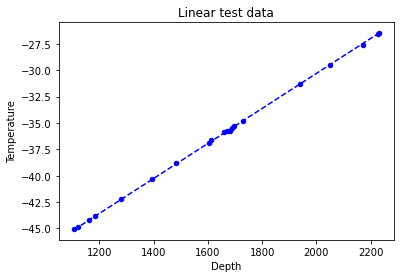

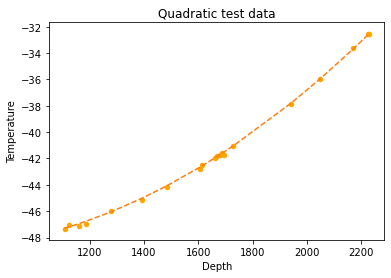

In [3]:
# defining model parameters for linear and quadratic fit (same values used to generate test data)
a0_lin, a1_lin = -6.35e1, 1.66e-2
a0_quad, a1_quad, a2_quad = -4.66e1, -7.47e-3, 6.18e-6

# linear test data
test_linear = io.load_ice_data("test_data_linear.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_linear.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1, color='blue')
x = test_linear['Depth'].values
print('The likelihood value for the linear model with the test data is {:.2e}'.format(m.calc_linear_likelihood(test_linear, a1_lin, a0_lin)))
x.sort()
plt.plot(x, a1_lin*x + a0_lin, color='blue', linestyle='dashed')
plt.title("Linear test data")

# quadratic test data
test_quad = io.load_ice_data("test_data_quadratic.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, a2_quad*x**2 + a1_quad*x + a0_quad, linestyle='dashed')
plt.title("Quadratic test data")
print('The likelihood value for the quadrartc model with the test data is {:.2e}'.format(m.calc_quad_likelihood(test_quad, a2_quad, a1_quad, a0_quad)))

## Doing some inference on the test data

The function `fit_quad()` in `model.py` fits the data to a quadratic function using least-squares regression and extracts the relevant parameters and covariance matrix. Let's do some inference on the quadratic test data and see if our parameters agree to a reasonable extent. In this function, only the errors on the temperature are considered. 

Values used to generate data:
b = -46.6
m = -0.00747
q = 6.18e-06

Best fit values:
b = -46.3 ± 0.479
m = -0.00791 ± 0.000592
q = 6.33e-06 ± 1.77e-07


Text(0.5, 1.0, 'Quadratic test data with quadratic fit (parameters inferred)')

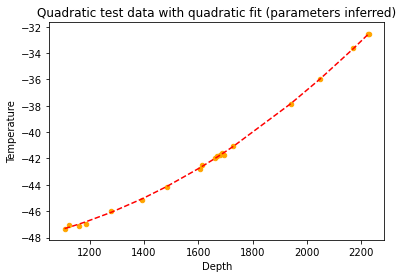

In [4]:
params, cov_mat = m.fit_quad(test_quad)

print("Values used to generate data:")
print("b = {:.3}".format(a0_quad))
print("m = {:.3}".format(a1_quad))
print("q = {:.3}".format(a2_quad))

# print formatting function adapted from HW 6 solutions
uncertainties = np.sqrt(np.diag(cov_mat))
print("\nBest fit values:")
for value, sigma, name in zip(params, uncertainties, 'bmq'):
    print('{} = {:.3} ± {:.3}'.format(name, value, sigma))

test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='red')
plt.title("Quadratic test data with quadratic fit (parameters inferred)")

Indeed, this simple inference returns the parameters with which we generated the test data within the errors.

## Inference on test data with MCMC

Also in `model.py` is the function `fit_quad_MCMC()`, which fits the data to a quadratic function and extracts the relevant parameters and covariance matrix, this time using `pymc3`, which utilizes MCMC sampling techniques. We previously defined our priors as Flat, but `pymc3` works more reliably when they are defined as bounded uniform priors (i.e. `Uniform(-100,100)`). Again, only the errors on the temperature are considered.

/Users/alexismulski/anaconda/envs/pymc3_env4/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [q, b, m]


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 34 seconds.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4929838178004008, but should be close to 0.8. Try to increase the number of tuning steps.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5118144102521892, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[-4.61435486e+01 -8.13121000e-03  6.39300000e-06]


Text(0.5, 1.0, 'Quadratic test data with quadratic fit (parameters from MCMC)')

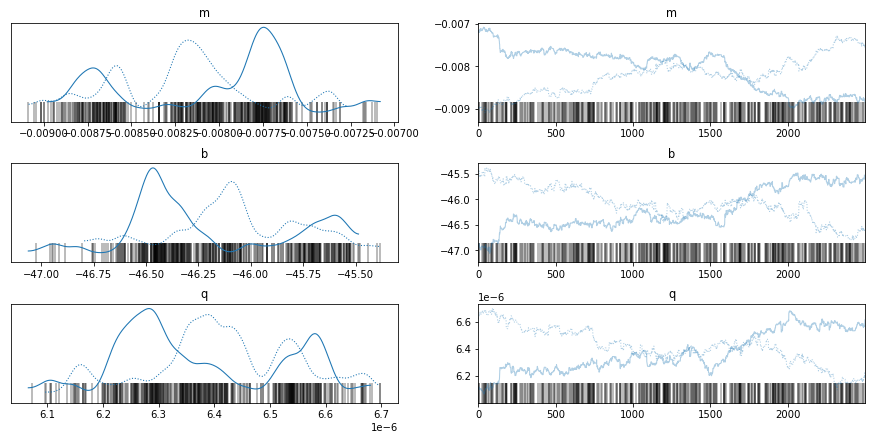

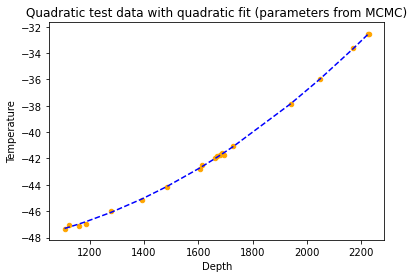

In [5]:
init_guess = {'b':0.00, 'm':0.00, 'q':0.00}
params, errors = m.fit_quad_MCMC(test_quad, init_guess) # returns params (and their errors) in order b, m, q
print(params)

test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='blue')
plt.title("Quadratic test data with quadratic fit (parameters from MCMC)")

Once again, the values obtained agree nicely with the values used to generate the test data.

## Doing some inference on the real data
Now that we know `fit_quad()` works with the test data, we can perform some inference on the real data from different years and extract the model parameters when we postulate a quadratic dependence between temperature and depth. For the purpose of keeping the tutorial notebook brief, only one data set/initial guess is demonstrated. 


Best fit values for real data of 2002:
b = -46.2 ± 0.201
m = -0.00849 ± 0.000257
q = 8.07e-06 ± 8.09e-08

Best fit values for real data of 2007:
b = -19.9 ± 12.9
m = -0.0336 ± 0.0114
q = 1.41e-05 ± 2.5e-06

Best fit values for real data of 2009:
b = -17.9 ± 12.9
m = -0.0353 ± 0.0114
q = 1.45e-05 ± 2.5e-06

Best fit values for real data of 2010:
b = -11.6 ± 12.9
m = -0.041 ± 0.0114
q = 1.58e-05 ± 2.5e-06


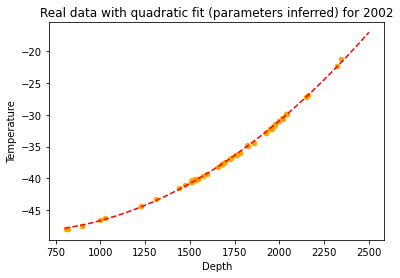

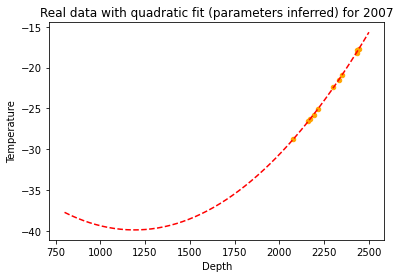

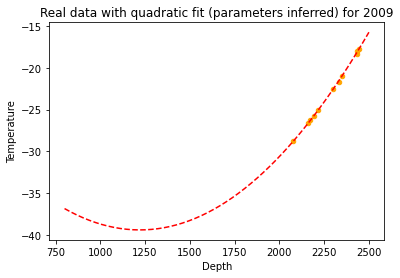

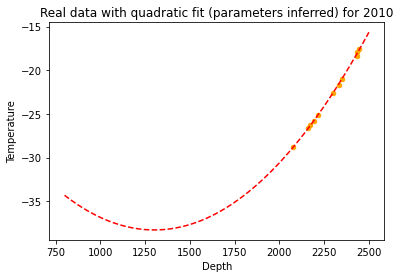

In [2]:
# load real data
data_2002 = io.load_ice_data("amanda_temp.txt", data_year=2002,temp_errors=0.1, depth_errors=2) 
data_2007 = io.load_ice_data("icecube_temp.2007.txt", data_year=2007,temp_errors=0.1, depth_errors=2)
data_2009 = io.load_ice_data("icecube_temp.2009.txt", data_year=2009,temp_errors=0.1, depth_errors=2)
data_2010 = io.load_ice_data("icecube_temp.2010.txt", data_year=2010,temp_errors=0.1, depth_errors=2)

data = [data_2002, data_2007, data_2009, data_2010]
x = np.linspace(800,2500)

for year in range(len(data)):
    params, cov_mat = m.fit_quad(data[year])

    # print formatting function adapted from HW 6 solutions
    uncertainties = np.sqrt(np.diag(cov_mat))
    print("\nBest fit values for real data of {}:".format(data[year]['data_year'][0]))
    for value, sigma, name in zip(params, uncertainties, 'bmq'):
        print('{} = {:.3} ± {:.3}'.format(name, value, sigma))

    x.sort()    
    data[year].plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
    plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='red')
    plt.title("Real data with quadratic fit (parameters inferred) for {}".format(data[year]['data_year'][0]))

## Inference on real data with MCMC

Using `fit_quad_MCMC()`, we infer the paramaters of our model on real data by performing MCMC sampling. We have kept the definition of the priors as bounded uniform priors (i.e. `Uniform(-100,100)`). As before, only the errors on the temperature are considered. We have adopted the initial guess to be similar to our previous results for polynomial fitting.

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [q, b, m]


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


Paremters from MCMC for the year 2002
[-4.61997163e+01 -8.49927200e-03  8.06800000e-06]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [q, b, m]


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 153 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Paremters from MCMC for the year 2007
[-2.01900262e+01 -3.33573030e-02  1.40670000e-05]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [q, b, m]


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 151 seconds.
The acceptance probability does not match the target. It is 0.8920310481835513, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Paremters from MCMC for the year 2009
[-1.70658649e+01 -3.60138690e-02  1.46210000e-05]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [q, b, m]


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 147 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Paremters from MCMC for the year 2010
[-1.19332494e+01 -4.07018720e-02  1.56850000e-05]


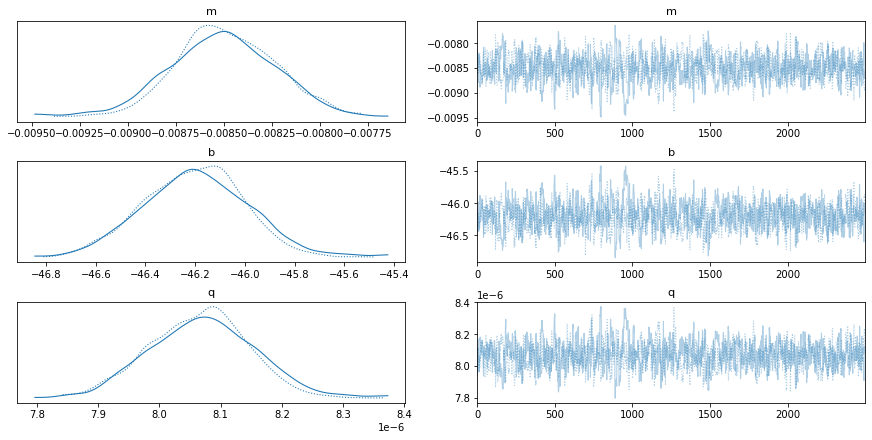

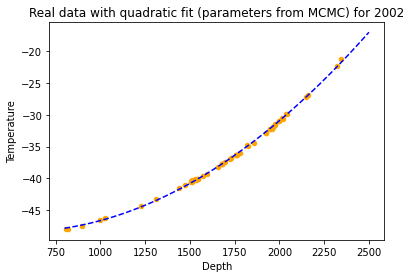

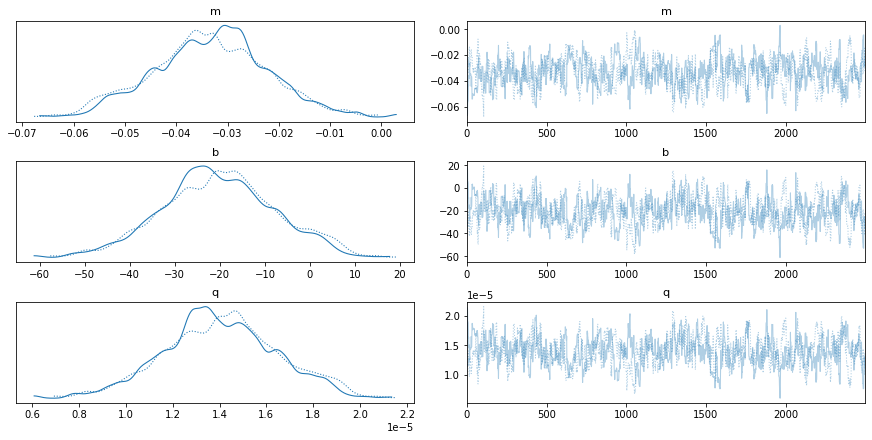

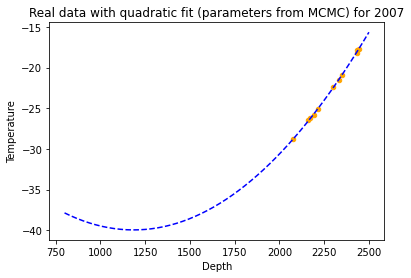

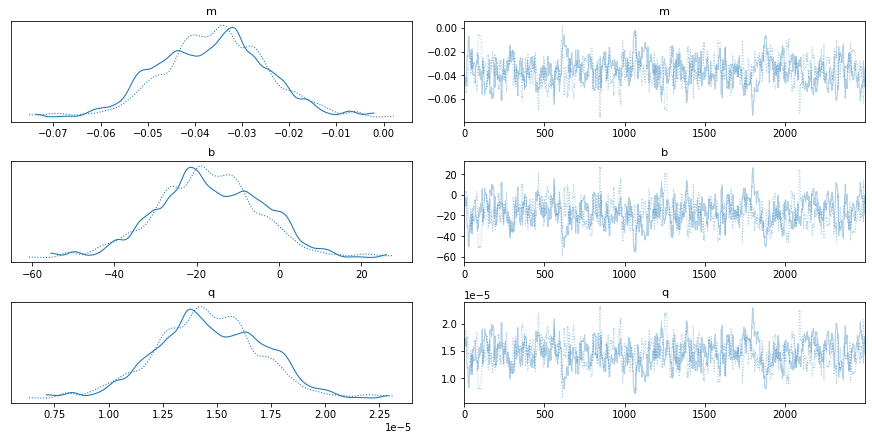

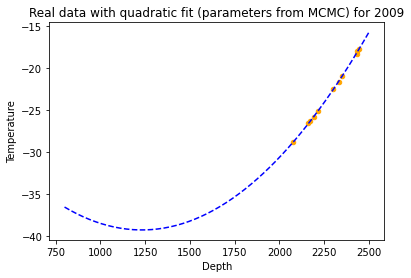

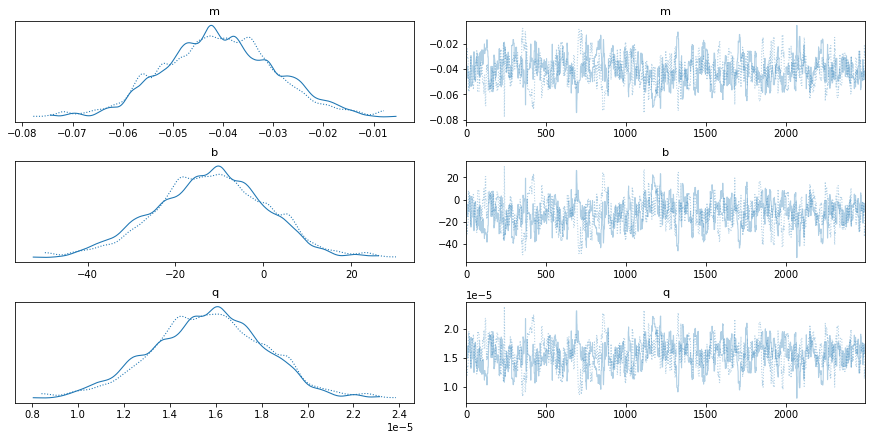

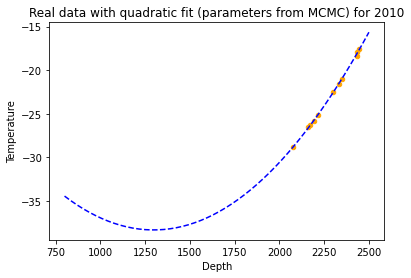

In [14]:
init_guess = {'b':-40, 'm':-0.0009, 'q':8.07e-06}

year_list = []
temp_list = []
pred_errs_list = []
for year in range(len(data)):
    params, errors = m.fit_quad_MCMC(data[year], init_guess) # returns params in order b, m, q
    print("Paremters from MCMC for the year {}".format(data[year]['data_year'][0]))
    print(params)
    
    year_list.append(data[year]['data_year'][0])
    temp_list.append(params[0])
    pred_errs_list.append(errors[0])
    
    data[year].plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
    plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='blue')
    plt.title("Real data with quadratic fit (parameters from MCMC) for {}".format(data[year]['data_year'][0]))

____
We have generalized our fitting function for any polynomial to the nth power. Using `n_polyfit_MCMC()`, we infer the paramaters of our model on real data by performing MCMC sampling. We have kept the definition of the priors as bounded uniform priors (i.e. `Uniform(-100,100)`). As before, only the errors on the temperature are considered. We have adopted the initial guess to be similar to our previous results for polynomial fitting.

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 35 seconds.
There were 396 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3990152397623452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9233478197706223, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Paremters from MCMC for the year 2002
[-4.61312578e+01 -8.58570500e-03  8.09400000e-06]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 184 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5413844910653118, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Paremters from MCMC for the year 2007
[-1.2756623e+01 -3.9890717e-02  1.5498000e-05]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 168 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9027400008958634, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Paremters from MCMC for the year 2009
[-1.74367664e+01 -3.56904400e-02  1.45500000e-05]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 160 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8996792016371231, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Paremters from MCMC for the year 2010
[-1.10847887e+01 -4.14467500e-02  1.58480000e-05]


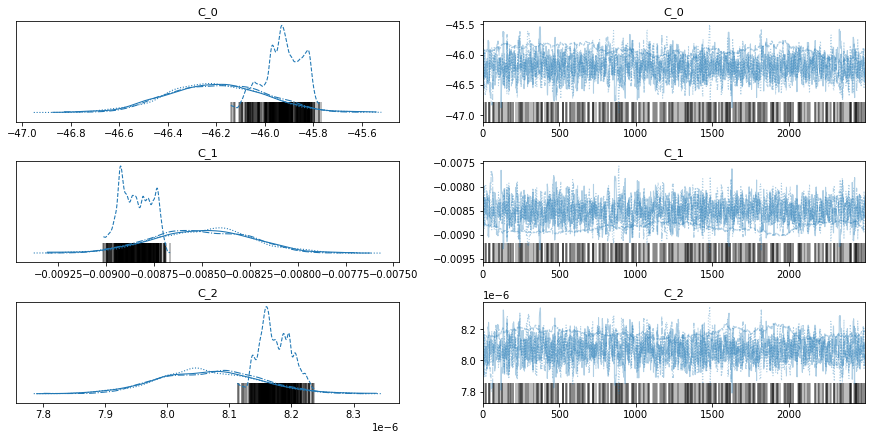

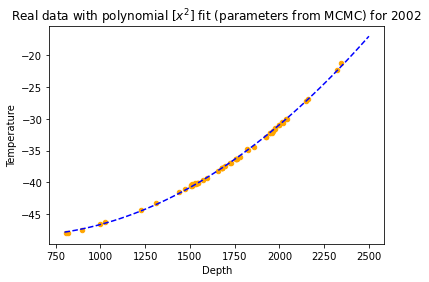

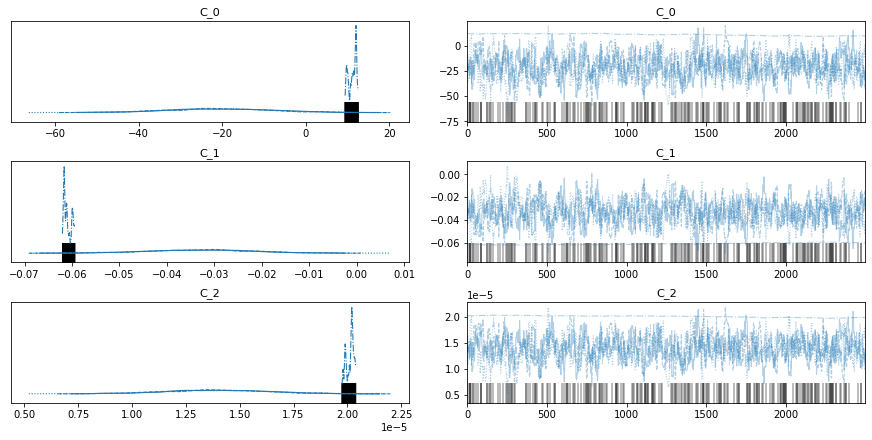

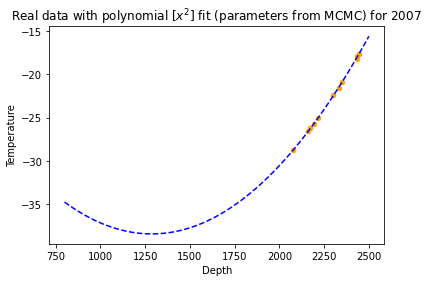

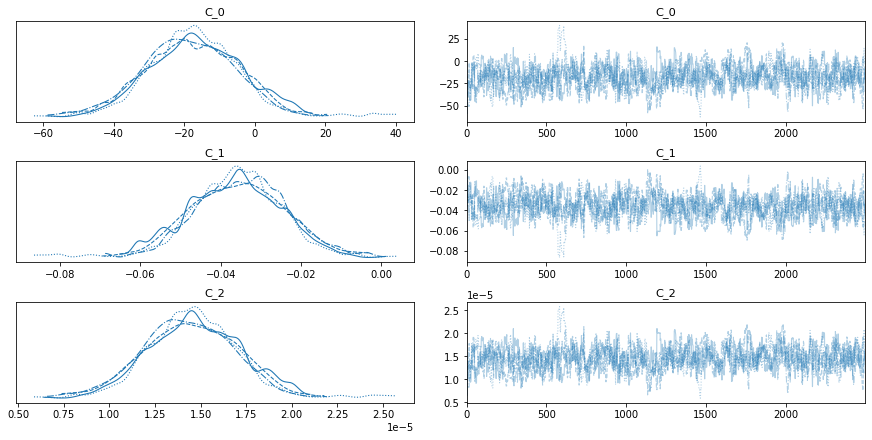

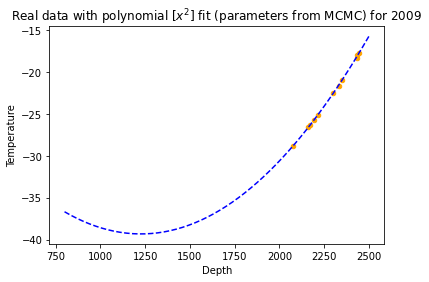

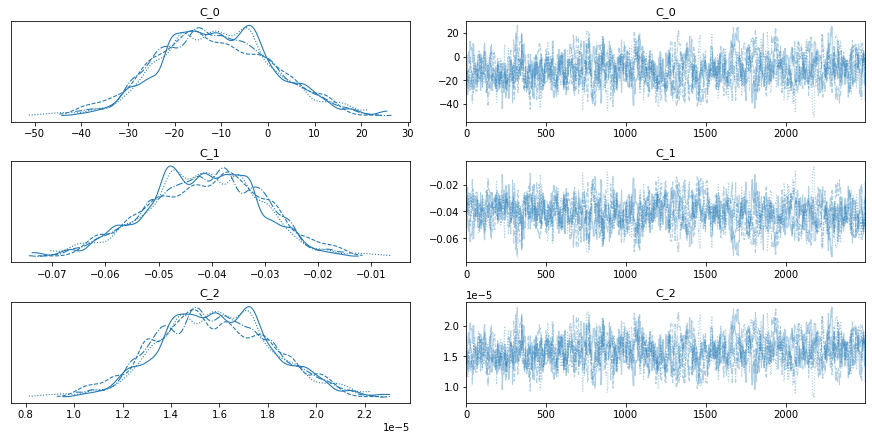

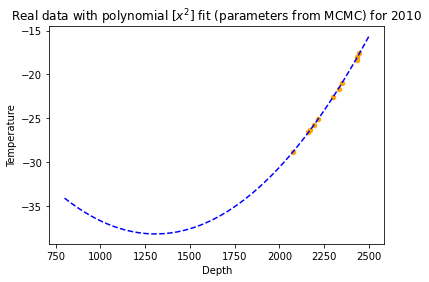

In [4]:
n = 2
timetable_poly_2 = m.get_timetable(n, data)

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 131 seconds.
The acceptance probability does not match the target. It is 0.9003247831297158, but should be close to 0.8. Try to increase the number of tuning steps.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5113091435277031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9217010721582876, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Paremters from MCMC for the year 2002
[-5.23219061e+01  4.63347300e-03 -7.27000000e-07  2.00000000e-09]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 259 seconds.
There were 461 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4593730040445211, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 457 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4623258679183249, but should be close to 0.8. Try to increase the number of tuning steps.
There were 527 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43890226725901305, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did

Paremters from MCMC for the year 2007
[ 4.31187474e+01 -1.17560894e-01  5.13010000e-05 -5.00000000e-09]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 260 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 704 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40815537145484193, but should be close to 0.8. Try to increase the number of tuning steps.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1048 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2511567524060756, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effe

Paremters from MCMC for the year 2009
[-2.15119123e+01 -2.80060230e-02  1.01660000e-05  1.00000000e-09]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 271 seconds.
The acceptance probability does not match the target. It is 0.9115428230758403, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4959323546876041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9434007144289502, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger 

Paremters from MCMC for the year 2010
[-2.94578586e+00 -5.33048040e-02  2.15580000e-05 -1.00000000e-09]


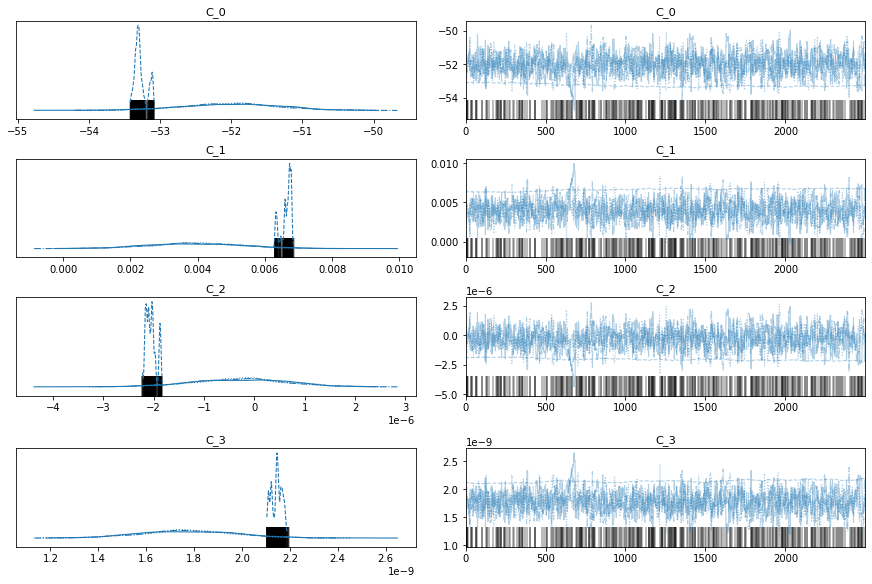

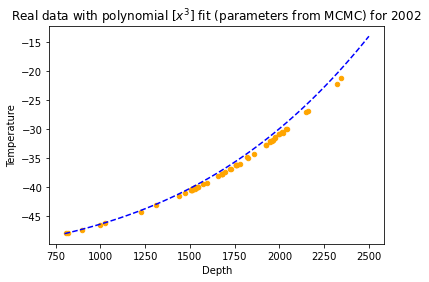

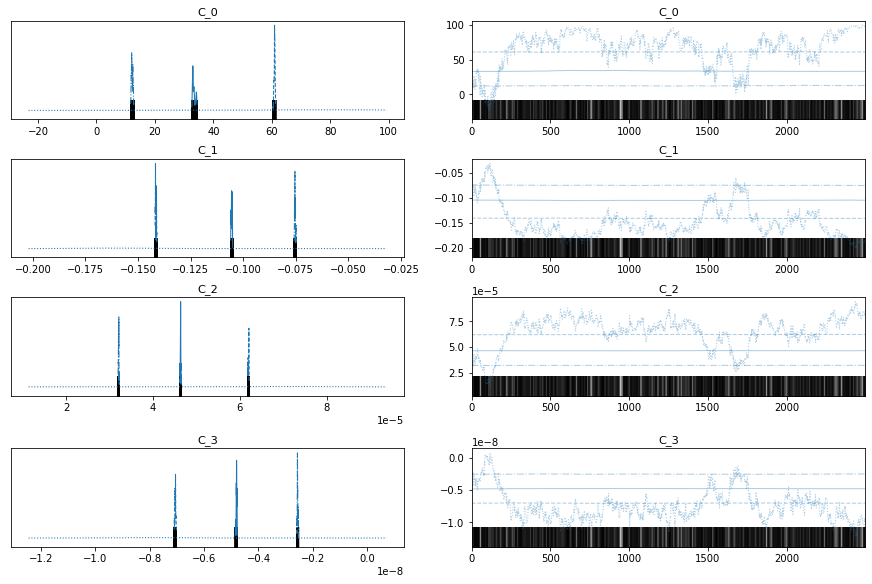

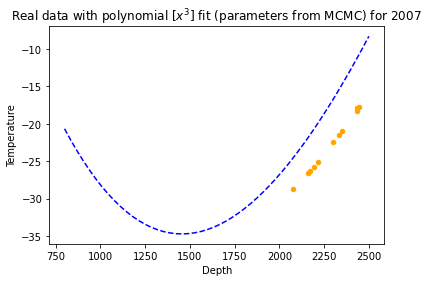

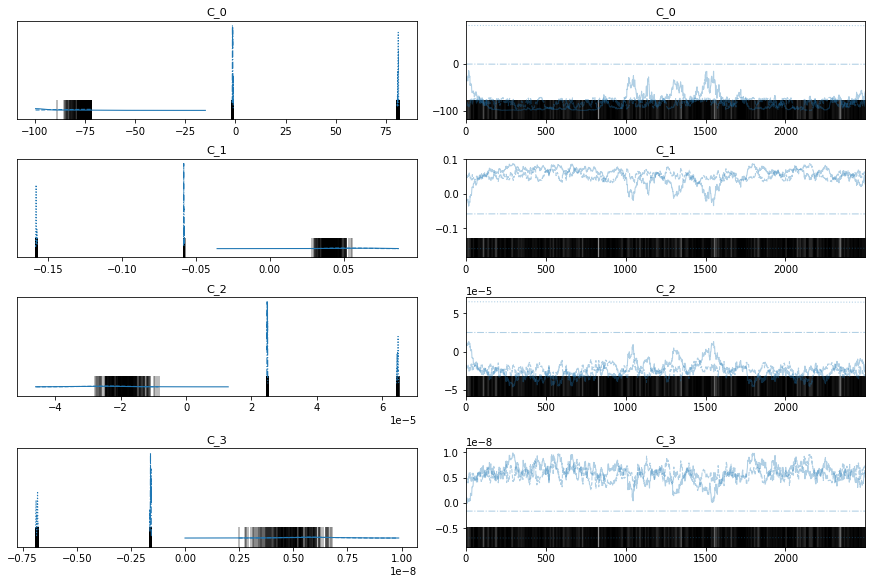

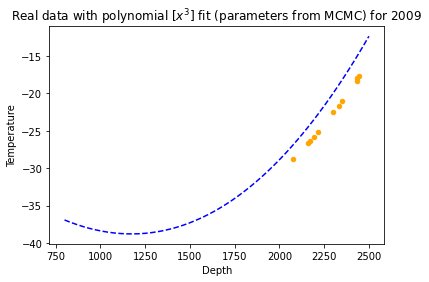

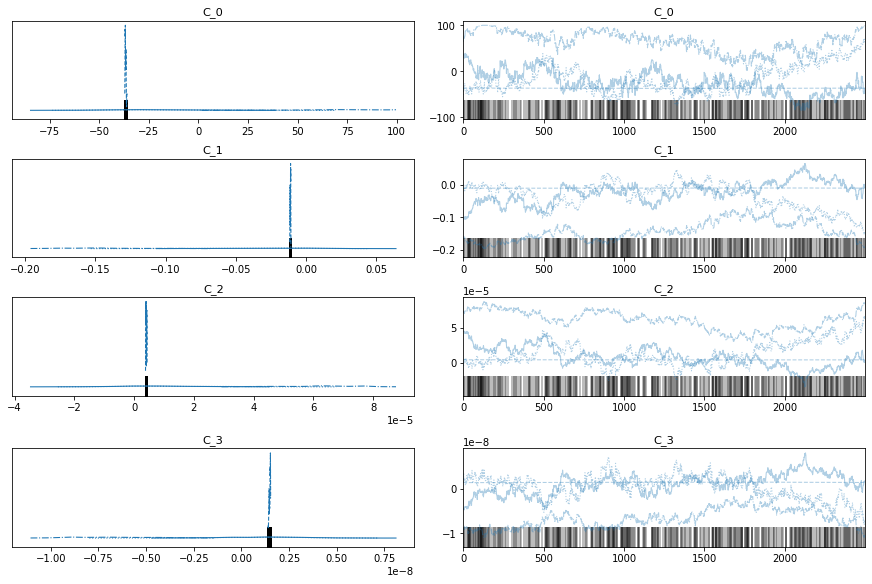

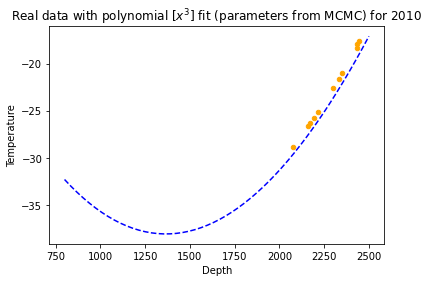

In [7]:
n = 3
timetable_poly_3 = m.get_timetable(n, data)

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_4, C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 182 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/usr/local/lib/python3.9/site-packa

Paremters from MCMC for the year 2002
[-0.0000e+00  0.0000e+00 -1.4057e-05  7.0000e-09 -0.0000e+00]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_4, C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 185 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1484 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.07165969824454267, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divi

Paremters from MCMC for the year 2007
[ 1.32e-07  0.00e+00 -7.76e-06  2.00e-09 -0.00e+00]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_4, C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 200 seconds.
There were 744 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 2.333637753189925e-48, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/usr/local/lib/python3.9/site-packages/arviz/st

Paremters from MCMC for the year 2009
[ 0.  0. -0. -0. -0.]


/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_4, C_3, C_2, C_1, C_0]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 104 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/usr/local/lib/python3.9/site-packages/arviz/stats/d

Paremters from MCMC for the year 2010
[-7.180e-07 -0.000e+00 -7.355e-06  3.000e-09 -0.000e+00]


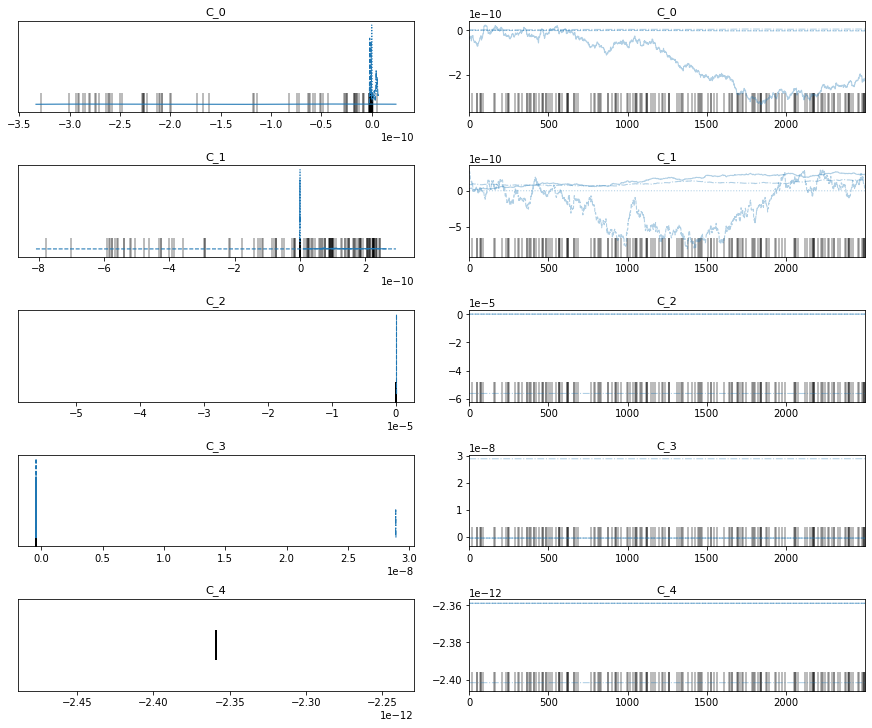

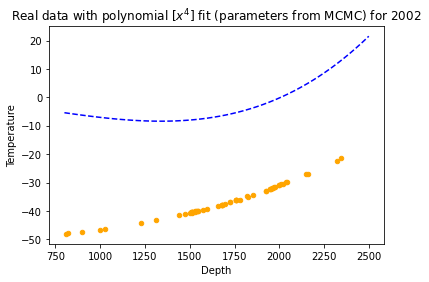

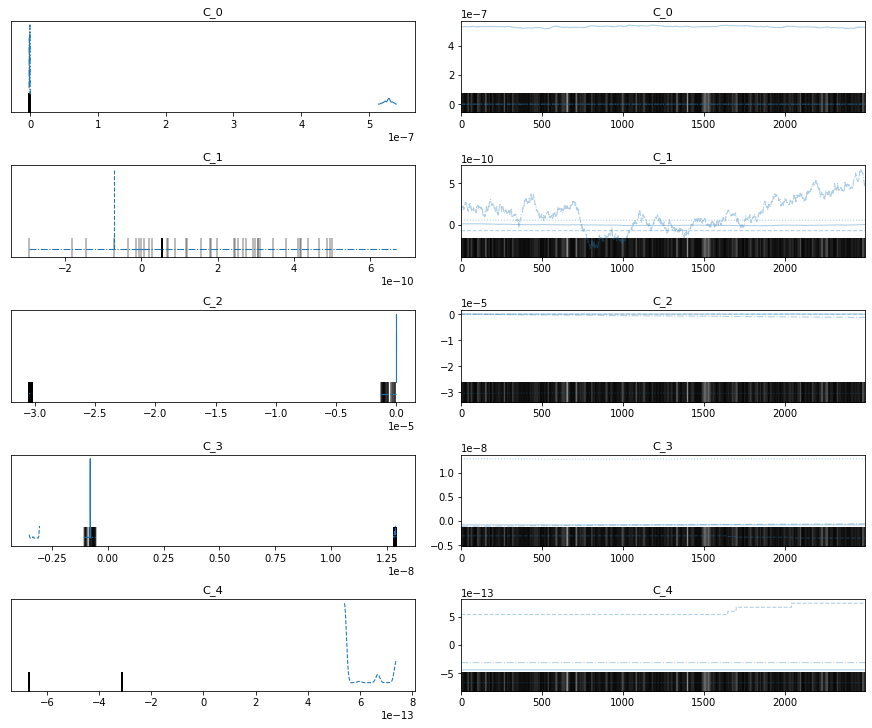

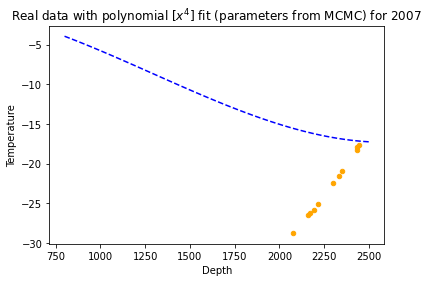

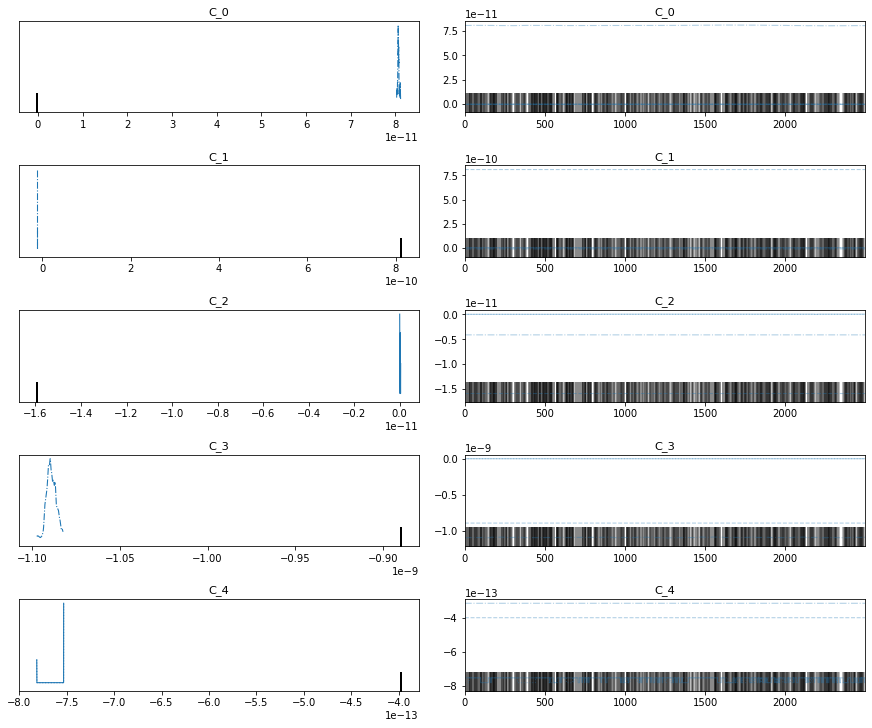

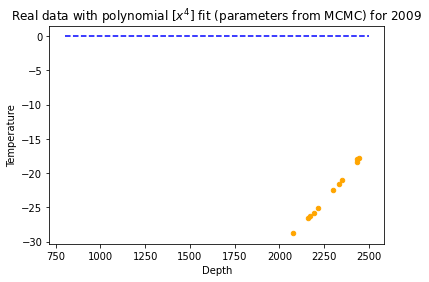

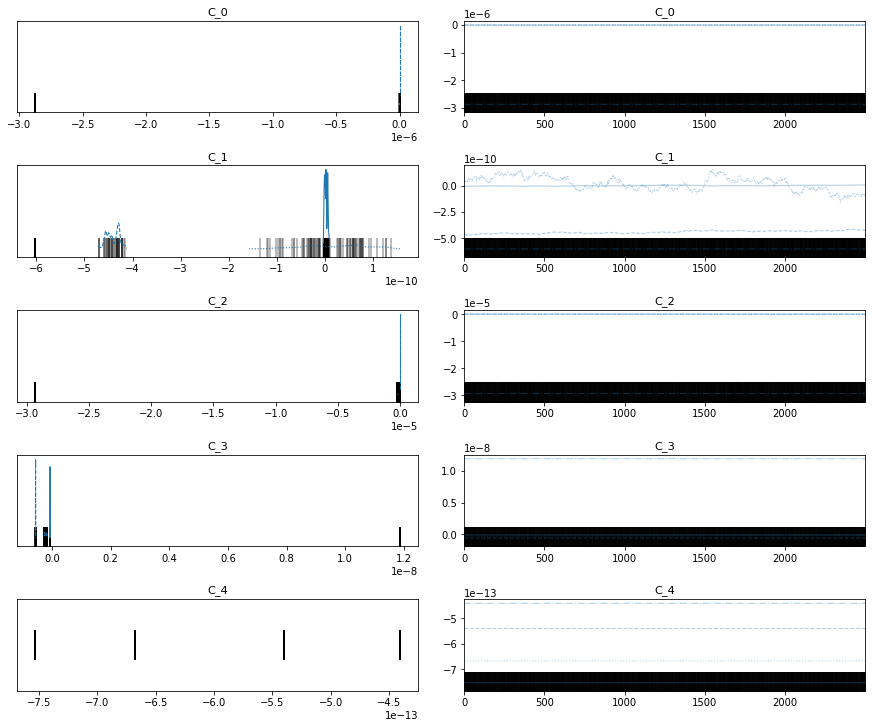

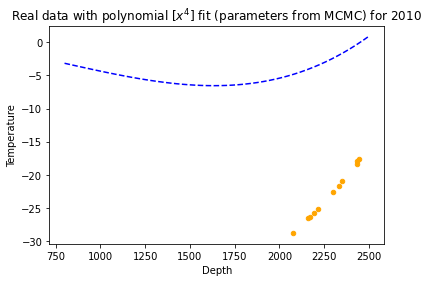

In [9]:
n = 4
timetable_poly_4 = m.get_timetable(n, data)

In [ ]:
n = 5
timetable_poly_5 = m.get_timetable(n, data)

In [ ]:
n = 6 
timetable_poly_6 = m.get_timetable(n, data)

___
___

# Incorporating data sets taken at different years to infer changes in surface temperature

As stated in the Overview, the overall goal of this package is to infer the temperature of the Antarctic surface at any given year based on ice temperature data collected between 2002 and 2010. From the thermistor data, we only receive data for temperature and depth, as shown in the figure below. The uncertaintes/noise sources are directly related to the thermistor technical limitations.

![Experimental Data](https://github.com/phys201/icetemp/blob/main/icetemp/south_pole_ice_temperature_data_release/south_pole_ice_temperature.png?raw=true)

This package uses  **Gaussian process regression (GPR)**  to estimate the temperature at ground level at any given time (year) with the approproate uncertainties. Gaussian processes are fully compatible with Bayesian inference. We will calculate the uncertainties from the posterior distribution obtained from inferring the temperature at the surface of the ice ($T_0$). GPR will generate a model that best fits the temperature change as a function of time at the surface of the Antartic ice.

### Let's take a look at our infered ground level temperatures for all our datatests.

   year  temperature  prediction_errors
0  2002   -46.131258           0.214519
1  2007   -12.756623          17.684949
2  2009   -17.436766          13.166539
3  2010   -11.084789          12.288559


Text(0.5, 0, 'Year')

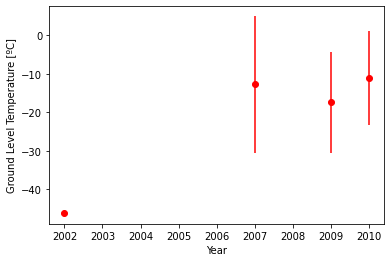

In [6]:
print(timetable_poly_2)

plt.errorbar(timetable_poly_2['year'], timetable_poly_2['temperature'], fmt='ro', yerr=timetable_poly_2['prediction_errors'])
plt.ylabel('Ground Level Temperature [ºC]')
plt.xlabel('Year')

   year  temperature  prediction_errors
0  2002   -52.321906           0.806088
1  2007    43.118747          25.154507
2  2009   -21.511912          68.648726
3  2010    -2.945786          45.728367


Text(0.5, 0, 'Year')

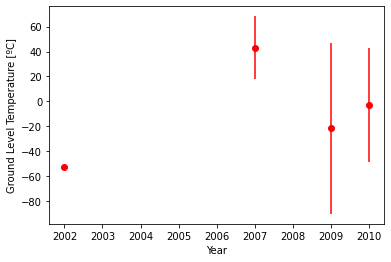

In [8]:
print(timetable_poly_3)

plt.errorbar(timetable_poly_3['year'], timetable_poly_3['temperature'], fmt='ro', yerr=timetable_poly_3['prediction_errors'])
plt.ylabel('Ground Level Temperature [ºC]')
plt.xlabel('Year')

## Inference at the surface of the ice with GPR

The function `fit_GPR()` in `model.py` performs GPR on the set of data points that include timing, temperature, and temperature predictive error information. In the future, we will use this approach to model the temperature at the surface of the Antarctic ice (taken as the intercepts of the fits from above) as a function of time, and will infer any warming rates from forecasted temperatures in the future. For now, let's look at dummy data.

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7161546793099244, but should be close to 0.8. Try to increase the number of tuning steps.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


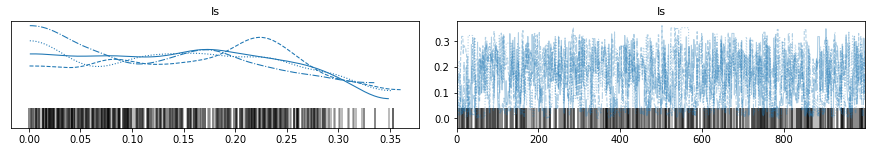

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


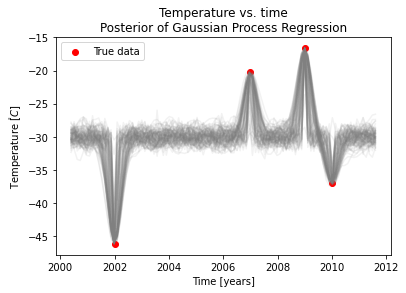

In [10]:
# dummy data
year_list_dummy = [2002, 2007, 2009, 2010]
temp_list_dummy = [-46.212995, -20.284988, -16.578483, -37.]
pred_errs_dummy = [0.1, 0.1, 0.1, 0.1]

timetable = pd.DataFrame({'year': year_list_dummy, 
                          'temperature': temp_list_dummy, 
                          'prediction_errors': pred_errs_dummy})
gpr_model = m.fit_GPR(timetable)

/Users/Josh/Desktop/physics201/icetemp/icetemp/model.py:299: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9008317961598689, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/Users/Josh/anaconda3/envs/env2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings

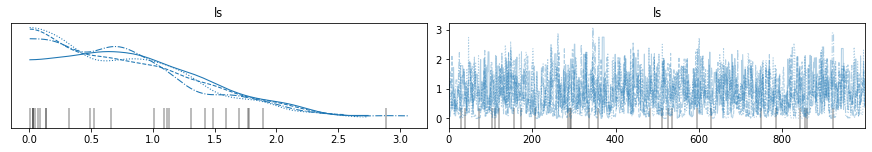

/Users/Josh/anaconda3/envs/env2/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


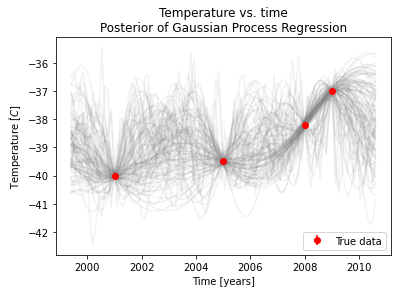

In [2]:
# dummy data
year_list_dummy = [2001, 2005, 2008, 2009]
temp_list_dummy = [-40., -39.5, -38.2, -37.]
pred_errs_dummy = [0.1, 0.1, 0.1, 0.1]

timetable = pd.DataFrame({'year': year_list_dummy, 
                          'temperature': temp_list_dummy, 
                          'prediction_errors': pred_errs_dummy})
gpr_model = m.fit_GPR(timetable)